In [0]:
import math
import random
from statistics import mean

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches

import numpy as np

迷路の形状、報酬を決める

In [0]:
world_width = 10
world_height = 4

reward_goal = 100
reward_cliff = -10
reward_move = -1

cliffs = []
for i in range(1, world_width-1):
    cliffs.append((i, 0))

walls = []

goals = []
goals.append((world_width-1, 0))

In [0]:
# 割引率γ
gamma = 0.9

# 学習率α
alpha = 0.1

# 1エピソードあたり最大何回行動するか
# (理想的には無限回だが適当なところで打ち切る)
max_iter = 100

# 何回エピソードを経験させるか
n_episodes = 10000

In [0]:
# 取りうる行動
# 完全にランダムでもよいが、ここでは右に40%、
# それ以外の方向にはそれぞれ20%の確率で動くようにした

actions = (
    (0, 1), # 上
    (1, 0), # 右
    (0, -1), # 下
    (-1, 0)) #左

action_weights = (0.2, 0.4, 0.2, 0.2)

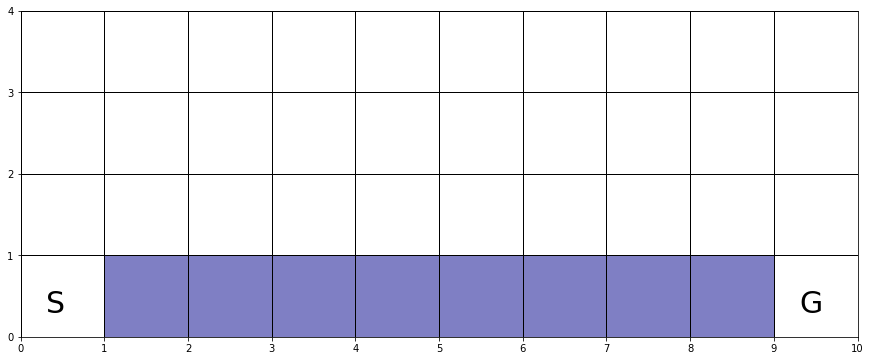

In [0]:
#@title 問題を表示する
def draw_world(history=None, marker_pos=None, values=None, qualities=None):
    global cliffs, walls, reward_goal, reward_cliff, reward_move
    fig = plt.figure(figsize=(world_width*1.5, world_height*1.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlim(0, world_width)
    ax.set_ylim(0, world_height)
    ax.grid(which='major', axis='x', color='k', alpha=1, linestyle='-', linewidth=1)
    ax.grid(which='major', axis='y', color='k', alpha=1, linestyle='-', linewidth=1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    for c in cliffs:
        r = patches.Rectangle(xy=c, width=1, height=1, ec='k', fc='darkblue', alpha=0.5)
        ax.add_patch(r)

    for w in walls:
        r = patches.Rectangle(xy=w, width=1, height=1, ec='k', fc='darkgray')
        ax.add_patch(r)

    if marker_pos is not None:
        c = patches.Circle(xy=(marker_pos[0]+0.5, marker_pos[1]+0.5), radius=0.25, ec='r', fill=False)
        ax.add_patch(c)

    if values is not None:
        vv = np.nan_to_num(values, nan=0, posinf=0, neginf=0)
        vmax = np.max(vv)
        vmin = np.min(vv)
        for x in range(world_width):
            for y in range(world_height):
                col = (np.clip(values[x][y], vmin, vmax) - vmin) / (vmax - vmin)
                col = np.clip(math.atan(10 * col), 0, 1)
                r = patches.Rectangle(xy=(x,y), width=1, height=1, ec='k', fc=(0, col, 0, 0.6))
                ax.add_patch(r)
                ax.text(x + 0.3, y + 0.3, f'{values[x][y]:.1f}', size=10)

    if qualities is not None:
        qq = np.nan_to_num(qualities, nan=0, posinf=0, neginf=0)
        qmax = max([v for q in Q.values() for v in q.values()])
        qmin = min([v for q in Q.values() for v in q.values()])
        label_offset = (
            (0.4, 0.8),
            (0.65, 0.5),
            (0.4, 0.1),
            (0.05, 0.5)
        )
        shapes = (
            ((0, 1), (1, 1)),
            ((1, 1), (1, 0)),
            ((0, 0), (1, 0)),
            ((0, 0), (0, 1))
        )
        for x in range(world_width):
            for y in range(world_height):
                no_explore = True
                for a in actions:
                    q = qq[(x,y)][a]
                    if q != 0.0:
                        no_explore = False

                for a, s, o in zip(actions, shapes, label_offset):
                    q = qq[(x,y)][a]

                    if no_explore:
                        fc = (0, 0, 0, 0.0)
                    else:
                        col = (np.clip(q, qmin, qmax) - qmin) / (qmax - qmin)
                        col = np.clip(math.atan(3 * col), 0, 1)
                        fc = (0, col, 0, 0.2)

                    t = patches.Polygon(((x+0.5, y+0.5), (x+s[0][0], y+s[0][1]), (x+s[1][0], y+s[1][1])), ec='k', fc=fc)
                    ax.add_patch(t)
                    ax.text(x + o[0], y + o[1], f'{q:.1f}', size=10)

    if history is not None:
        X = []
        Y = []
        U = []
        V = []
        x = history[0][0]
        y = history[0][1]
        for i, p in enumerate(history):
            if i == 0:
                continue
            new_x = history[i][0]
            new_y = history[i][1]
            
            if True: #not (new_x == 0 and new_y == 0):
                X.append(x)
                Y.append(y)
                new_x += np.random.normal(0, 0.05)
                new_y += np.random.normal(0, 0.05)
                U.append(new_x - x)
                V.append(new_y - y)
            x = new_x
            y = new_y
        
        X = np.array(X) + 0.5
        Y = np.array(Y) + 0.5
        U = np.array(U)
        V = np.array(V)
        ax.quiver(X, Y, U, V, scale=1, scale_units='xy')

    ax.text(0.3, 0.3, 'S', size=30)
    ax.text(world_width - 1 + 0.3, 0.3, 'G', size=30)
    return ax

draw_world()

In [0]:
# 実際に動かしてみる関数
def do_action(s, a):
    reward = 0
    x, y = s
    new_x = x + a[0]
    new_y = y + a[1]
    
    finish = False

    reward += reward_move

    # 迷路の外に飛び出さない
    if new_x < 0 or new_y < 0 or new_x >= world_width or new_y >= world_height:
        new_x = x
        new_y = y

    # 壁にぶつかったらそれ以上進めない
    elif (new_x, new_y) in walls:
        new_x = x
        new_y = y

    # 崖に落ちたら初期位置に戻る
    elif (new_x, new_y) in cliffs:
        new_x = 0
        new_y = 0
        reward += reward_cliff
        finish = True

    # ゴールに着いたとき
    elif (new_x, new_y) in goals:
        reward += reward_goal
        finish = True

    return (new_x, new_y), reward, finish

In [0]:
# ランダムな位置からスタート
def set_start_pos():
    return 0, 0

In [0]:
def get_next_action(state, epsilon):
    if random.random() < epsilon:
        action = random.choice(actions)
    else:
        action = max(Q[state], key=Q[state].get)
    return action

In [0]:
def init_Q():
    Q = { }
    for y in range(world_height):
        for x in range(world_width):
            Q[(x, y)] = { }
            for a in actions:
                Q[(x, y)][a] = 0.0
    return Q

In [0]:
# 求めたQに基づいてε-greedyで動く
# 今sにいるとすると、Q(s, a)が最も高くなるaを選んで行動する
# ただしε-greedyで動いているので確率εでランダムに動く
def calc_route(Q):
    x,y = 0, 0
    history = [(x, y)]

    for i in range(max_iter):
        if np.random.rand() < 0.01:
            # Explore
            action = random.choice(actions)
        else:
            # Exploit
            #action = actions[np.array(candidates).argmax()]
            action = max(Q[(x,y)], key=Q[(x,y)].get)

        (x, y), _, finish = do_action((x, y), action)
        history.append((x, y))

        if (x, y) in goals:
            break
        
    return history

In [0]:
def plot_results(log_epsilon, log_reward):
    x = np.arange(0, n_episodes, 1)
    plt.figure(figsize=(10, 5))
    plt.subplot('121')
    plt.plot(x, log_epsilon, c='blue')
    plt.title('ε')
    plt.subplot('122')
    plt.plot(x, log_reward, c='orange')
    plt.title('total reward')
    plt.plot()

## SARSA

SARSAでQを求めてみます。
SARSAでは自分の現在の方策に基づいて行動を選択しています `next_action = get_next_action(state, epsilon)` 。
その結果を使って Q の更新を行う部分がQ学習との違いです。
Q値の学習に現在の方策を使うので**方策オン**型、あるいは**on-policy**な方法と呼ばれます。

結果を見ると、最短コースではなくすこし遠回りしていることがわかります。Qの計算のときに自分の方策を使うので、「確率εでランダムな動きをしてしまい、崖に落ちるかもしれない」というリスクを込みで計算しているともいえます。そのため崖に落ちないように若干距離をとった経路が求まります。

reward:  84.51484848484849


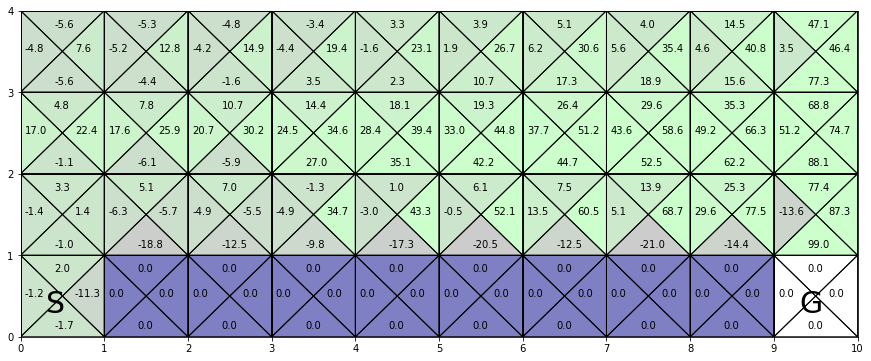

In [0]:
Q = init_Q()

log_epsilon = [ ]
log_reward = [ ]

for episode in range(n_episodes):
    # エージェントをスタート地点に移動
    state = (0, 0)
    total_reward = 0
    pos_history = [state] # あとで経路を可視化したいので行動ログをとる
    epsilon = 1 / (episode / 100 + 1)
    
    # 最大max_iter回行動してみる
    # もしゴールについたらエピソード終了
    for k in range(max_iter):
        action = get_next_action(state, epsilon)
        next_state, reward, finish = do_action(state, action)
        total_reward += reward
        next_action = get_next_action(state, epsilon)

        # Q値を更新 (SARSAとQ学習の違いはここだけです)
        Q[state][action] = Q[state][action] + alpha * ((reward + gamma * Q[next_state][next_action]) - Q[state][action])
        
        state = next_state
        pos_history.append(state)

        # ゴールに着いたら終わり
        if finish:
            break
    log_epsilon.append(epsilon)
    log_reward.append(total_reward)

draw_world(qualities=Q).plot()

# 最後の100ステップでの平均報酬
print('reward: ', mean(log_reward[100:]))

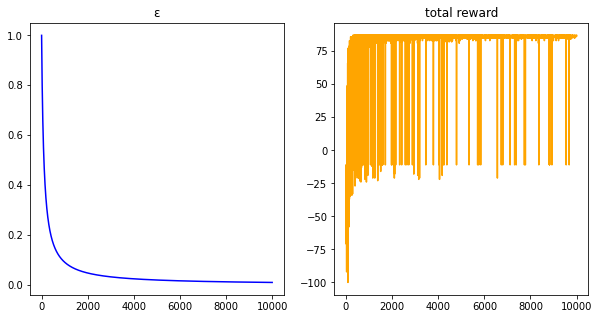

In [0]:
plot_results(log_epsilon, log_reward)

[]

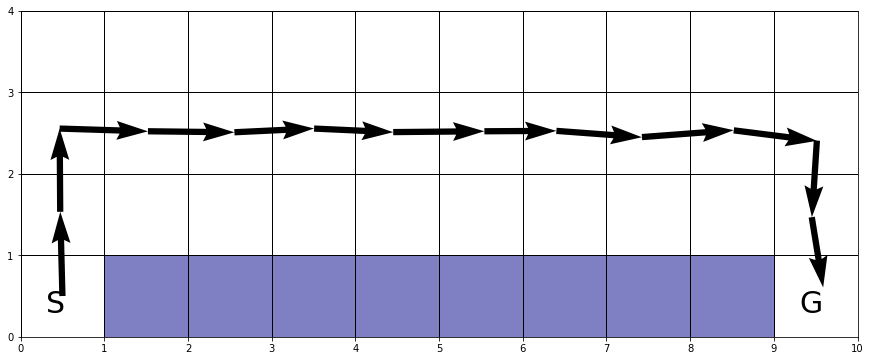

In [0]:
draw_world(history=calc_route(Q)).plot()

## Q学習

Q学習でも解を求めてみます。

Q学習ではQ値の計算のときに自分の方策を考えません。SARSAでは自分の方策に基づいて次の行動を決めていましたが、Q学習では単にQ(s,a)が最大になるa(`max_action`)を使って値を更新します。ただし、この `max_action` はQ値の計算のときだけ使って、実際の次の行動はSARSA同様 `next_action = get_next_action(state, epsilon)` になることに注意してください。

Q学習のほうは最短経路が求まるのですが、ε-greedyに基づいて動いていることには変わりないので、たまに崖に落ちてしまいます。うまくいけば高い報酬が手に入るものの、平均報酬はSARSAに負けています(パラメータなどにもよって変わります)。

reward:  79.94181818181818


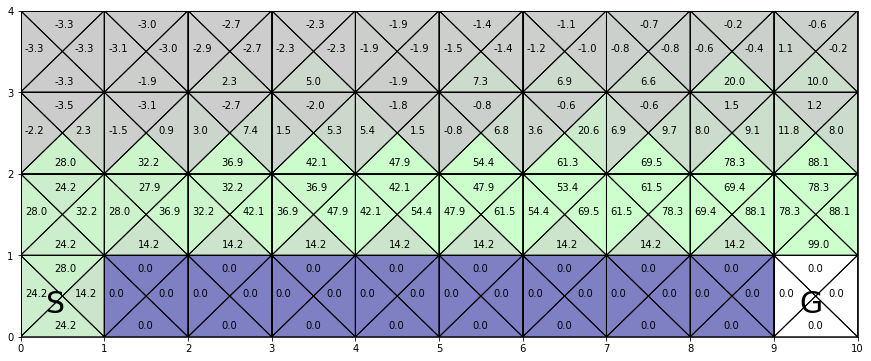

In [0]:
Q = init_Q()

log_epsilon = [ ]
log_reward = [ ]

for episode in range(n_episodes):
    # エージェントをスタート地点に移動
    state = (0, 0)
    total_reward = 0
    pos_history = [state] # あとで経路を可視化したいので行動ログをとる
    epsilon = 1 / (episode / 100 + 1)

    # 最大max_iter回行動してみる
    # もしゴールについたらエピソード終了
    for k in range(max_iter):
        action = get_next_action(state, epsilon)
        next_state, reward, finish = do_action(state, action)
        total_reward += reward
        next_action = get_next_action(state, epsilon)

        # Q値を更新 (SARSAとQ学習の違いはここだけです)
        max_action = max(Q[next_state], key=Q[next_state].get)
        Q[state][action] = Q[state][action] + alpha * ((reward + gamma * Q[next_state][max_action]) - Q[state][action])
        
        state = next_state
        pos_history.append(state)

        # ゴールに着いたら終わり
        if finish:
            break
    log_epsilon.append(epsilon)
    log_reward.append(total_reward)

draw_world(qualities=Q).plot()

# 最後の100ステップでの平均報酬
print('reward: ', mean(log_reward[100:]))

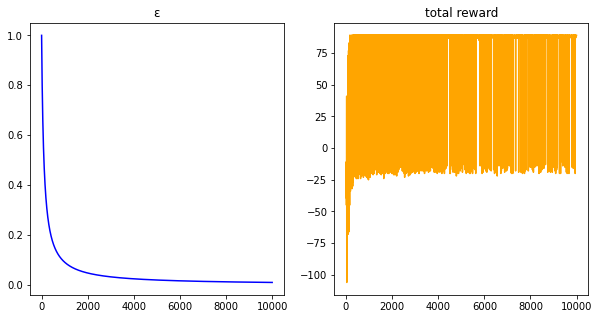

In [0]:
plot_results(log_epsilon, log_reward)

[]

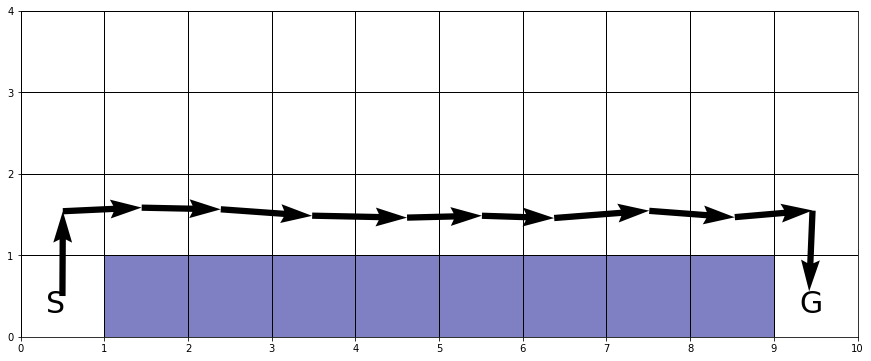

In [0]:
draw_world(history=calc_route(Q)).plot()